In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
file = '/Users/orion/Downloads/saas.csv'
# with open(file) as f:
#     data = f.read

In [3]:
df = pd.read_csv(file)

In [4]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [6]:
df['date'] = pd.to_datetime(df.Month_Invoiced)

In [7]:
df.set_index(df.date, inplace=True)
df.drop(columns=['Month_Invoiced', 'date'], inplace=True)

In [8]:
aggregation = 'sum'

In [9]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)

print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 36
Testing Observations: 12


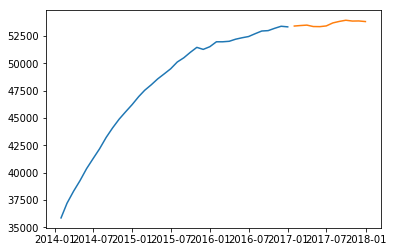

In [10]:
plt.plot(train)
plt.plot(test)
plt.show()

In [11]:
ts_data = df.Amount.resample('M').agg(aggregation)

train_size = int(len(ts_data) * 0.66)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

Observations: 48
Training Observations: 31
Testing Observations: 17


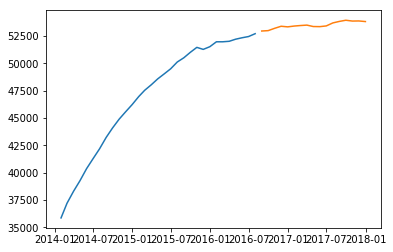

In [12]:
plt.plot(train_1)
plt.plot(test_1)
plt.show()

In [13]:
yhat = pd.DataFrame(dict(actual=test))

yhat['avg_forecast'] = train.sum()

In [14]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()   

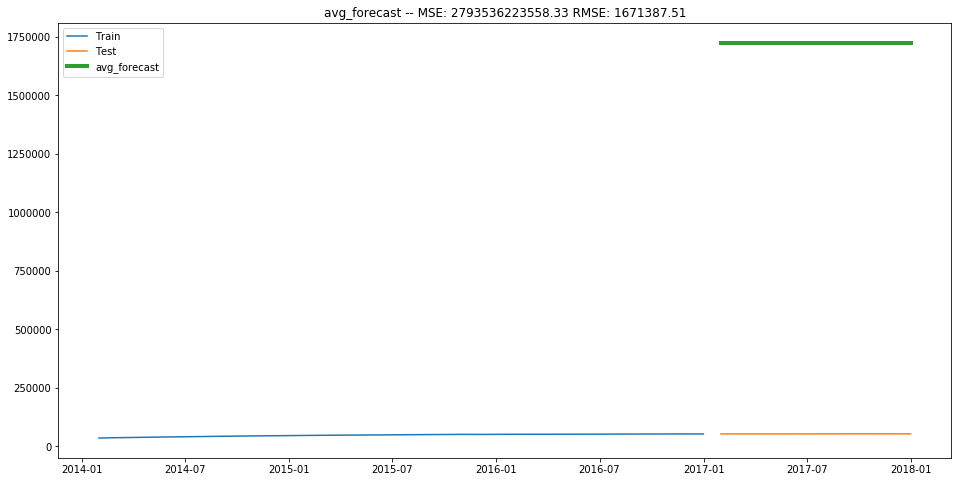

In [15]:
plot_and_eval(yhat.avg_forecast)

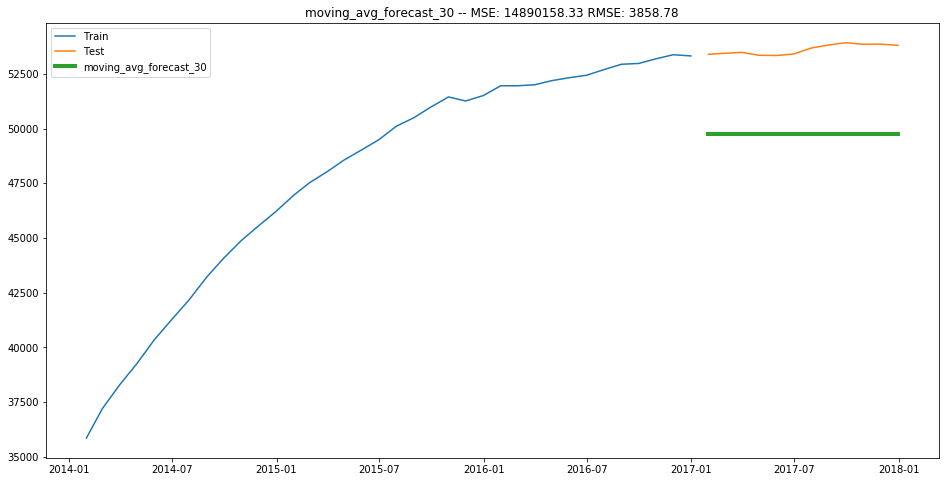

In [16]:
periods = 180
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_30)

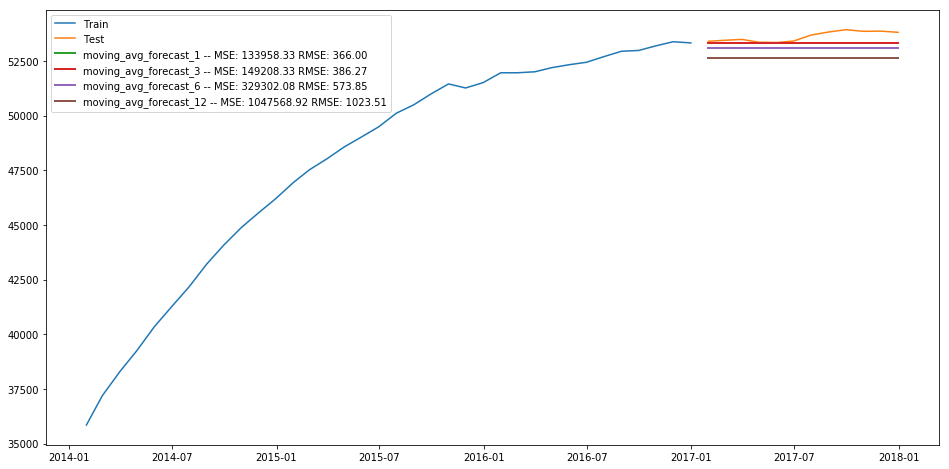

In [17]:
period_vals = [1, 3, 6, 12]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

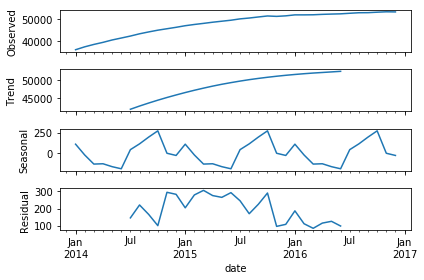

In [18]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

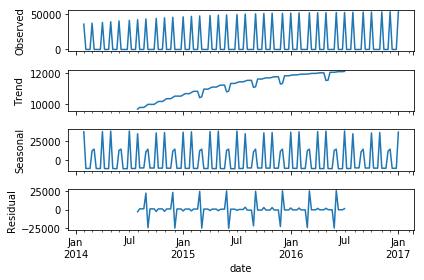

In [19]:
train = df[:'2016'].Amount.resample('W').agg(aggregation)
test = df['2017':].Amount.resample('W').agg(aggregation)

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

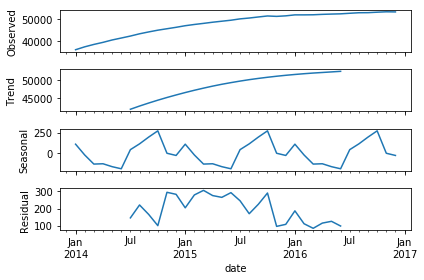

In [20]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

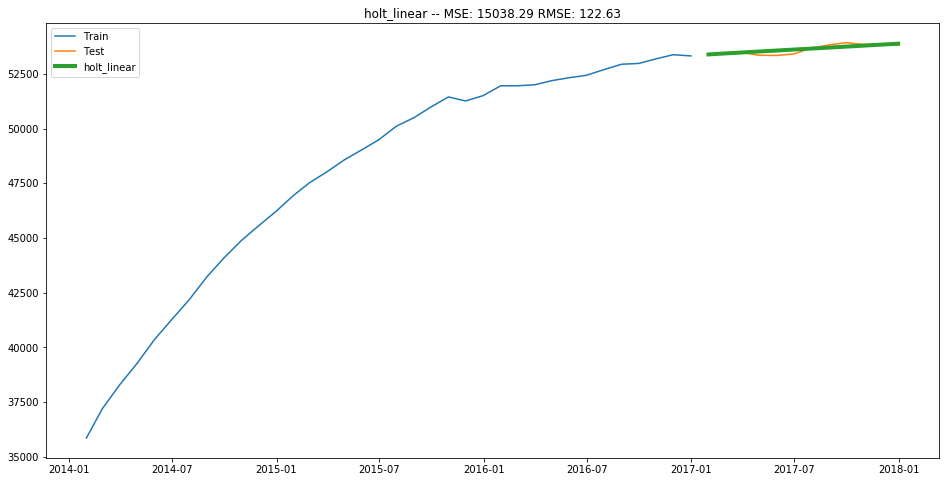

In [21]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.649700000000000001)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

In [32]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2016'].index + 12)

yhat['last_year'] = using_last_year

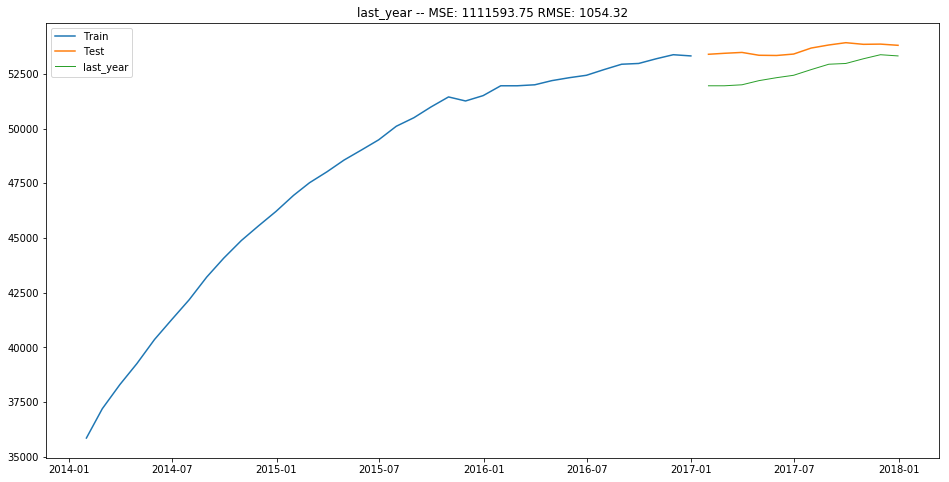

In [33]:
plot_and_eval(yhat.last_year, linewidth=1)

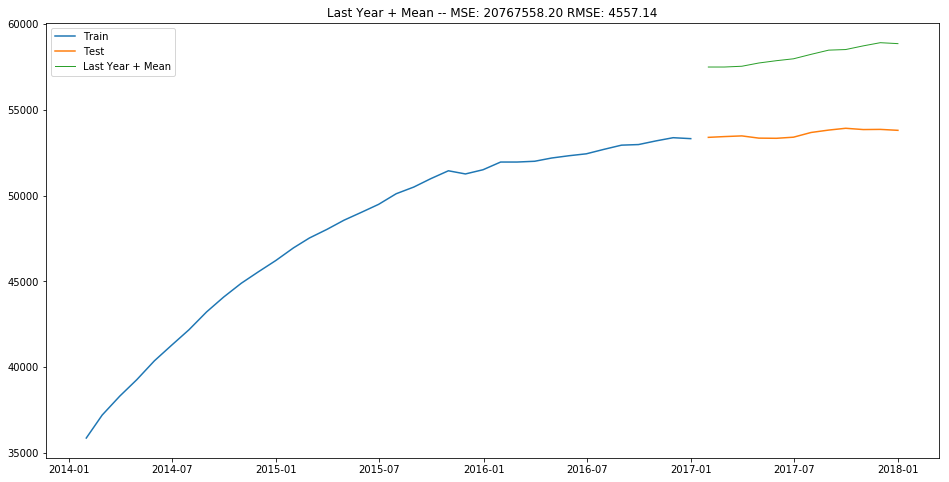

In [37]:
predictions = train['2016'] + train.diff(12).mean()
predictions.index = pd.date_range('20170101', periods=12, freq='M')
predictions = predictions
predictions.name = 'Last Year + Mean'

plot_and_eval(predictions, linewidth=1)